In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
from PIL import Image
from bs4 import BeautifulSoup
import torch
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset

In [3]:
images_path = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector/images"
annots_path = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector/annotations"

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [5]:
def createLabelFromXml(annot_path):
    fp = open(annot_path, "r")
    soup = BeautifulSoup(fp, "xml")
    
    width = int(soup.find('width').text)
    height = int(soup.find('height').text)

    xmin = int(soup.find('xmin').text)
    xmax = int(soup.find('xmax').text)
    ymin = int(soup.find('ymin').text)
    ymax = int(soup.find('ymax').text)

    xmin /= width
    xmax /= width
    ymin /= height
    ymax /= height
    
    box =  [xmin, xmax, ymin, ymax] # used as an input of the model
    
    return box

In [6]:
class LicensePlateDataset(Dataset):
    def __init__(self, mode='train', split_ratio=0.8, transform=None):
        self.mode = mode
        self.transform = transform
        self.images = glob.glob(f"{images_path}/*.png")
        self.length = len(self.images)
        self.split_ratio = split_ratio
        self.len_train = int(self.length * self.split_ratio)
        self.len_test = self.length - self.len_train
        
    def __getitem__(self, idx):
        if self.mode == 'train':
          image_path = f"{images_path}/Cars{idx}.png"
          annot_path = f"{annots_path}/Cars{idx}.xml"
        else:
          idx = self.len_train + idx
          image_path = f"{images_path}/Cars{idx}.png"
          annot_path = f"{annots_path}/Cars{idx}.xml"

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = createLabelFromXml(annot_path)
        tLabel = torch.as_tensor(label, device=device)
        

        return image, tLabel

    def __len__(self):
        if self.mode == 'train':
          return self.len_train
        return self.len_test

In [7]:
transform = torchvision.transforms.Compose([
                  torchvision.transforms.Resize((224, 224)),
                  torchvision.transforms.ToTensor()
])

train_dataset = LicensePlateDataset(mode='train', split_ratio=0.8, transform=transform)
valid_dataset = LicensePlateDataset(mode='valid', split_ratio=0.2, transform=transform)

In [8]:
import torch.nn as nn
model = models.resnet101(pretrained=True)
model = nn.Sequential(
    model,
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 250),
    nn.ReLU(),
    nn.Linear(250, 4),
    nn.Sigmoid(),
)
model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [9]:
learning_rate = 0.001
num_epochs = 100

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

In [10]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
filepath = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector"
modelpath = "model"

model.load_state_dict(torch.load(f"{filepath}/{modelpath}/model_state_dict.pt"))
optimizer.load_state_dict(torch.load(f"{filepath}/{modelpath}/optim_state_dict.pt"))

In [13]:


import time

start = time.time()
count = 0
error = nn.MSELoss()

globalMinLoss = float('inf')
model.train()
print("-------Running-------")
for epoch in range(num_epochs):

    for (images, labels) in train_loader:
        #print(f"({count}/{len(train_loader)})")
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images.view(batch_size, 3, 224, 224))
        
        loss = error(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        count += 1
  
    if count % 10 == 0:
        with torch.no_grad():
              # predicted = torch.max(outputs.data, 1)[1]
              # valid_loss = error(outputs, labels)

              valid_loss = 0
              valid_count = 0
              # Iterate through test dataset
              for images, labels in valid_loader:
                  images = images.to(device)
                  # Forward propagation
                  outputs = model(images.view(batch_size, 3, 224, 224))
                  valid_loss += error(outputs, labels)
                  valid_count += 1
                  
              valid_loss /= valid_count
              if valid_loss < globalMinLoss:
                  globelMinLoss = valid_loss
                  best_model_state = model.state_dict()
                  best_optim_state = optimizer.state_dict()
                  torch.save(best_model_state, f"{filepath}/{modelpath}/model_state_dict.pt")
                  torch.save(best_optim_state, f"{filepath}/{modelpath}/optim_state_dict.pt")
                  print("Successfully saved.")
        

        print(f"""{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())} || [{epoch}/{num_epochs}], train_loss = {loss.data}, valid_loss = {valid_loss.data}""")
print("-------End------")
elapsed = time.time() - start
print(f"End of training, elapsed time : {elapsed // 60} min {elapsed % 60} sec.")

-------Running-------


KeyboardInterrupt: ignored

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector"
modelpath = "model"
if best_model_state is not None and best_optim_state is not None:
    torch.save(best_model_state, f"{filepath}/{modelpath}/model_state_dict.pt")
    torch.save(best_optim_state, f"{filepath}/{modelpath}/optim_state_dict.pt")
    print("Successfully saved.")

Successfully saved.


In [12]:
def customEval(idx):
    
    images_path = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector/images"
    annots_path = "/content/drive/MyDrive/Colab Notebooks/2022/Car License Plate Detector/annotations"

    image_path = f"{images_path}/Cars{idx}.png"
    annot_path = f"{annots_path}/Cars{idx}.xml"

    image = Image.open(image_path)
    imageTensor = image.convert("RGB")
    imageTensor = transform(imageTensor).to(device)

    label = createLabelFromXml(annot_path)

    model.eval()

    output = model(imageTensor.view(1, 3, 224, 224))
    return output.tolist()[0], label, image_path

Image shape is (375, 500)


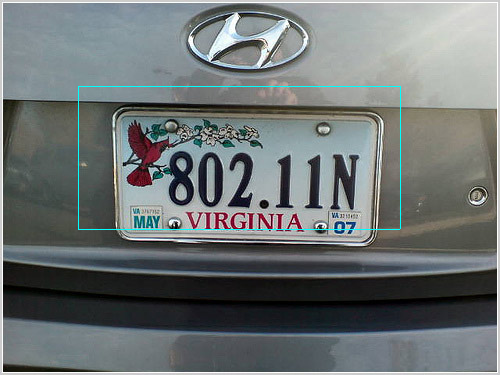

In [17]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow



[xmin_pred, xmax_pred, ymin_pred, ymax_pred], label, _ = customEval(6)

img_org = cv2.imread(image_path)
img = img_org.copy()
col, row, _ = img.shape

print(f"Image shape is {col, row}")

xmin_pred = int(row * xmin_pred)
xmax_pred = int(row * xmax_pred)
ymin_pred = int(col * ymin_pred)
ymax_pred = int(col * ymax_pred)

img[ymin_pred, xmin_pred:xmax_pred, :] = [255, 255, 0]
img[ymax_pred, xmin_pred:xmax_pred, :] = [255, 255, 0]
img[ymin_pred:ymax_pred, xmin_pred, :] = [255, 255, 0]
img[ymin_pred:ymax_pred, xmax_pred, :] = [255, 255, 0]
cv2_imshow(img)

In [24]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,261 kB/s)
debconf: unable to initi

In [22]:
import pytesseract as pt

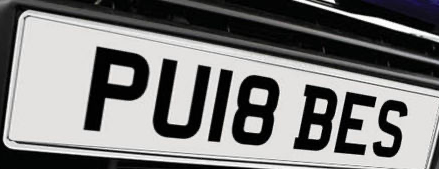

In [48]:
idx = 4
output, label, image_path = customEval(idx)
image = cv2.imread(image_path)
col, row, _ = image.shape
xmin = int(output[0]*row)
xmax = int(output[1]*row)
ymin = int(output[2]*col)
ymax = int(output[3]*col)

plateImage = image[ymin:ymax, xmin:xmax, :]
cv2_imshow(plateImage)

In [49]:
text = pt.image_to_string(plateImage)
text

' \n\x0c'

In [50]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
    return cv2.Canny(image, 100, 200)

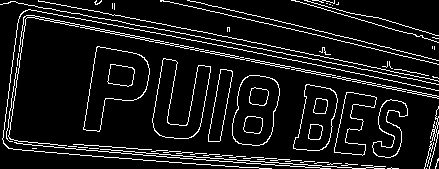

In [51]:
gray = get_grayscale(plateImage)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
cv2_imshow(canny)

In [52]:
text = pt.image_to_string(canny)
text

' \n\x0c'